In [77]:
#import packages
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from datetime import date 
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import statsmodels.api as sm
import duckdb, sqlalchemy

%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


## Research Questions

1. Is there a significant difference between weather trends when moving about 100 miles away from a central location?
2. Does a trace amount of precipitation indicate that the next day is more likely to experience precipitation? Does this depend on the region?
3. Is it possible to accurately model and predict the weather based on another location’s weather?


# Introduction 

This analysis aims to investigate weather phenomena in Ithaca and surrounding cities. For this study Ithaca was chosen as the central location, and then one city North, South, East, and West of Ithaca was chosen to include 5 cities total. The data for each city comes from the National Weather Service. This study is intended to be mainly applicable to a Northeastern climate, and focuses on location, time of year, precipitation, and temperature as the main predictors and indicators of weather. One of the main findings is that only for certain seasons is weather significantly different 100 miles away from Ithaca. Another finding is that only in certain regions is there more likely to be precipitation the day after a trace of precipitation is detected. Last, it is possible to build a good model to predict temperature using latitude, longitude, year, and month.


## Data Cleaning



We obtained our data through 3 data requests to weather.gov. First, we requested Ithaca's data, and then we decided to expand out analysis to include locations north, east, south, and west of Ithaca. Our second data pull included the following cities: Watertown (North), Bloomsburg (South), Cobleskill (East), and Avoca (West). Avoca did not contain any temperature data, so we decided to request data for Erie as a replacement. The cell below, reads in the cleaned csv file that also merges the csv files obtained from weather.gov. The full data cleaning process is contained in an additional notebook found here: https://github.com/margaretquirk7/info2950.

In [78]:
#read in csv
agg_df = pd.read_csv("agg_df.csv")

## Data Description

Each row in this dataset is a date ranging from 2000 to 2022, and location, which is either Ithaca, Bloomsburg, Erie, Watertown, or Cobleskill. The data was received in three separate files, as the National Weather Service sends one file for each request. First Ithaca data was requested to test the data quality, and understand attributes provided. Then 4 more cities were requested, and were provided in one file. However, one of these cities was missing temperature data, so we chose to request a different city, thus resulting in a third file. We then combined these files to include 5 cities with Ithaca at the center. The columns in this data set are as follows: 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'DAPR', 'DAPR_ATTRIBUTES', 'MDPR', 'MDPR_ATTRIBUTES', 'PRCP', 'PRCP_ATTRIBUTES', 'SNOW', 'SNOW_ATTRIBUTES', 'SNWD', 'SNWD_ATTRIBUTES', 'TMAX', 'TMAX_ATTRIBUTES', 'TMIN', 'TMIN_ATTRIBUTES', 'WESD', 'WESD_ATTRIBUTES', 'WESF', 'WESF_ATTRIBUTES', 'WT05', 'WT05_ATTRIBUTES', 'Location', 'Precip Trace', and 'Snow Trace'. The dataset created by combining cities has 71,144 rows and 27 columns.

This dataset was created as a record of past observable weather events, and is used to predict future events, and train models. The data comes from the National Weather Service, which is a federally funded agency, whose job is to provide weather forecasts and other weather information, including data, in the public domain. The National Weather Service uses their own remote sensing equipment as well as working with some local weather stations to collect data. Therefore, the data was directly observable through the use of weather hardware apparatuses including thermometers, rain gauges, snow boards, and yardsticks. Since these tools were used, people and surveying were not involved in this data creation. Depending on the equipment available in the chosen cities, some of the null columns may exist because the proper tools to record such an observation were not available. Meanwhile, other null values may have occurred because there was not a reliable weather station in the chosen locations at a certain time, since all the locations are relatively rural. Some of the preprocessing that occurred is data filtering to only include observations in the desired locations, and qualitative attributes for various weather conditions, such as snow or rain, being added based on corresponding columns.

Raw data source

Ithaca data: https://drive.google.com/file/d/1nqrr9H8sJTQJVXNlwPeIdXmr4nBxcg7M/view?usp=sharing

Other city data: https://drive.google.com/file/d/19-Uf3W-ls7k7-OtloUc4hNisYEYgmxmf/view?usp=sharing

Erie data: https://drive.google.com/file/d/1kqY8DdBSWfDtdshsmF35hZYGRaoIHsY3/view?usp=sharing


## Preregistration Statement

The first hypothesis we want to investigate is: the average temperature is significantly different between regions for each season. We anticipate that the northern and southern cities will have significantly different temperatures, since they are located at varying distances from the equator, but the eastern and western cities we expect will not have significantly different temperatures since they’re located at similar latitudes. The purpose of this hypothesis is to either support or refute the commonly accepted theory that temperature decreases the further away one moves from the equator.

Our second hypothesis is: there is a higher likelihood of a trace of precipitation if the following or previous day recorded precipitation greater than 0. The purpose of this hypothesis is to evaluate if we can predict precipitation using historical data with any significant success. The results of this investigation could be helpful in giving people the ability to anticipate hazardous conditions and plan ahead if they expect weather to impede travel.

Our final hypothesis is: we can create a model that accurately predicts temperature based on longitude, latitude, and time of year. If we can successfully predict temperature, this would be incredibly useful for a person’s day-to-day life. For example, if someone is planning on moving somewhere new or going on vacation, being able to predict the temperature in the location for the period of time that they’re there would be critical for knowing what to bring with them.



## Initial Data Analysis

For the first stage of our exploratory data analysis, we printed the summary statistics for the dataframe containing all the regions and the summary statistics for each region individually. Overall, the statistics appear similar across the regions. The Southern region appears to be slightly warmer compared to the rest, and the snowfall is highest in the North. In the following phases, we plan on exploring further into seasonality and how it affects the summary statistics and trends.

In [79]:
#Summary statistics for each region
agg_list = [central, north, south, east, west]
title_list = ['Central', 'North', 'South', 'East','West']
print('All Regions')
print(round(agg_df[['MaxTemp','MinTemp','Precipitation','Snowfall','AverageTemp']].describe(),3))
print()
for i in range(0,5,1):
    print(title_list[i])
    print(round(agg_list[i][['MaxTemp','MinTemp','Precipitation','Snowfall','AverageTemp']].describe(),3))
    print()

All Regions
         MaxTemp    MinTemp  Precipitation   Snowfall  AverageTemp
count  34006.000  33645.000      34784.000  32645.000    33599.000
mean      57.259     38.860          0.122      0.232       48.044
std       20.271     18.931          0.271      1.070       19.226
min      -10.000    -44.000          0.000      0.000      -19.500
25%       40.000     26.000          0.000      0.000       33.500
50%       59.000     39.000          0.003      0.000       49.000
75%       75.000     55.000          0.117      0.000       64.500
max       98.000     80.000          5.270     25.000       88.000

Central
        MaxTemp   MinTemp  Precipitation  Snowfall  AverageTemp
count  8265.000  8265.000       8265.000  8265.000     8265.000
mean     57.118    37.478          0.110     0.180       47.298
std      20.336    18.008          0.259     0.785       18.801
min       0.000   -22.000          0.000     0.000      -10.000
25%      40.000    25.000          0.000     0.000      

The cell below produces 5 subplots of daily average temperature throughout 2017. We chose 2017 as it was the most recent year in which all regions had a substantial amount of temperature data. Our Southern region is missing a couple periods of temperature data within 2017, most notably in June. As expected, there is clear seasonality for each region.

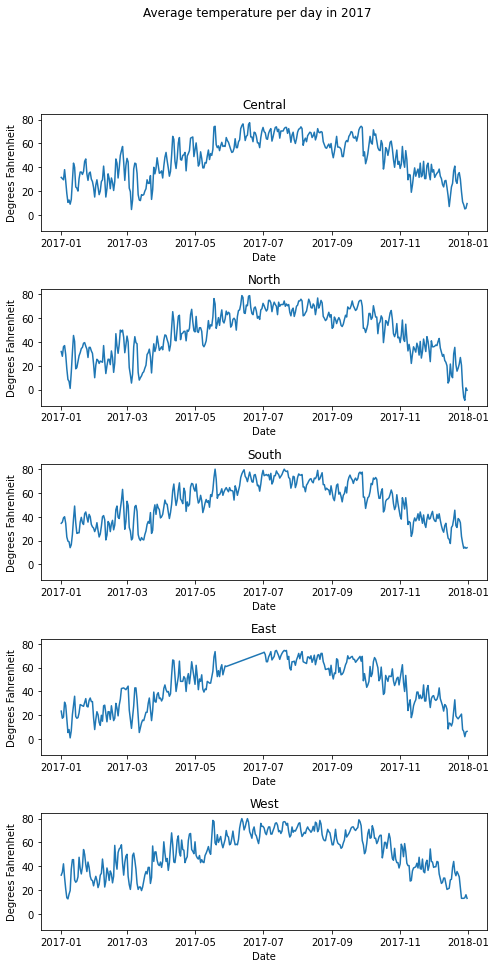

In [80]:
#temperature for sample year 2017
central_2017 = central[(central['DATE']>='2017-01-01')&(central['DATE']<= '2017-12-31')]
north_2017 = north[(north['DATE']>='2017-01-01')&(north['DATE']<= '2017-12-31')]
south_2017 = south[(south['DATE']>='2017-01-01')&(south['DATE']<= '2017-12-31')]
east_2017 = east[(east['DATE']>='2017-01-01')&(east['DATE']<= '2017-12-31')]
west_2017 = west[(west['DATE']>='2017-01-01')&(west['DATE']<= '2017-12-31')]

df_list = [central_2017, north_2017, south_2017, east_2017, west_2017]
fig, axs = plt.subplots(5, sharex = False, sharey=True, figsize = (8,15))
fig.suptitle('Average temperature per day in 2017')
fig.subplots_adjust(hspace = 0.5)
index = 0
title_list = ['Central', 'North', 'South', 'East','West']
for i in df_list:
    axs[index].plot(i['DATE'], i['AverageTemp'])
    axs[index].set_ylabel('Degrees Fahrenheit')
    axs[index].set_xlabel('Date')
    axs[index].set_title(title_list[index])
    index+=1

The code below creates a lineplot to compare average monthly temperature across the regions. It is incredibly difficult to distinguish between the regions which once again suggests the importance of breaking up the data by seasonality in future phases.

Returning data to local variable month_df


[Text(0.5, 1.0, 'Average Temperature by Month')]

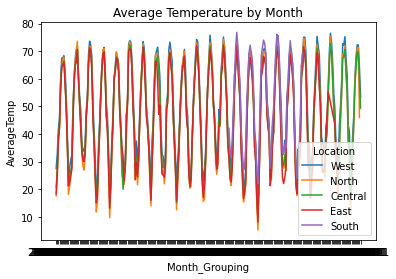

In [81]:
#line plot of temparature in each region over time
%sql month_df << select Month_Grouping, avg(AverageTemp) as AverageTemp, Location from agg_df group by Month_Grouping, Location order by Month_Grouping
sns.lineplot(x='Month_Grouping', y='AverageTemp', hue = 'Location', data = month_df).set(title = 'Average Temperature by Month')

The graph below shows a lineplot of total average annual rainfall across each of the regions. It is important to note that the Southern region did not begin collecting rainfall data until the end of 2011. It also appears that the Eastern region stopped collecting rainfall data in 2021.

Returning data to local variable precip_df


[Text(0.5, 1.0, 'Total Rainfall by Year in Inches')]

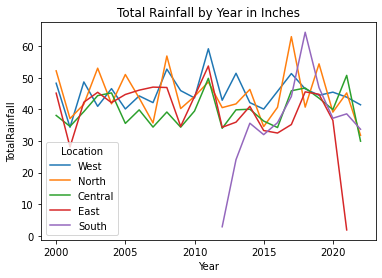

In [89]:
#Comparison of annual rainfall 
agg_df['DATE'] = pd.to_datetime(agg_df['DATE'], format = '%Y-%m-%d')
agg_df['Year'] = agg_df['DATE'].dt.year
%sql precip_df << select Year, Location, sum(Precipitation) as TotalRainfall, sum(Snowfall) as TotalSnowfall from agg_df group by Year, Location order by Year
precip_df['TotalPrecipitation'] = precip_df['TotalRainfall'] + precip_df['TotalSnowfall']
sns.lineplot(x='Year', y='TotalRainfall', hue = 'Location', data = precip_df).set(title = 'Total Rainfall by Year in Inches')

The graph below shows a lineplot of total average annual snowfall across each of the regions. Once again, the Southern region did not begin collecting snowfall data until the end of 2011, and it seems that the Eastern region stopped collecting data in 2021. In this plot, the Northern and Western region seem to have considerably higher snowfall levels compared to the other regions.

[Text(0.5, 1.0, 'Total Snowfall by Year in Inches')]

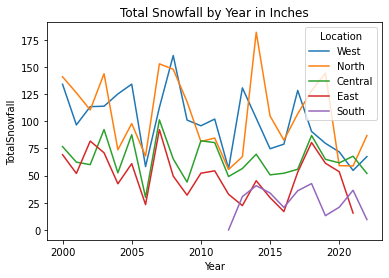

In [90]:
#Comparison of annual snowfall
sns.lineplot(x='Year', y='TotalSnowfall', hue = 'Location', data = precip_df).set(title = 'Total Snowfall by Year in Inches')

The plot below shows total annual precipitation across each region. The Northern and Western have the highest precipitation levels as expected due to the snowfall plot.

[Text(0.5, 1.0, 'Total Precipitation by Year in Inches')]

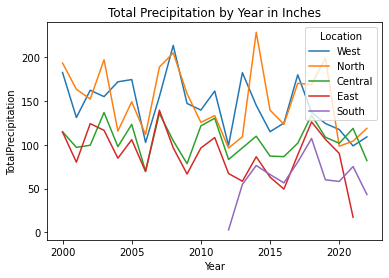

In [92]:
#Comparison of annual precipitation
sns.lineplot(x='Year', y='TotalPrecipitation', hue = 'Location', data = precip_df).set(title = 'Total Precipitation by Year in Inches')

Finally, we ran some summary statistics on the Trace columns for each region since we plan to conduct a logistic regression with these variables in the following phase. It is interesting to note that the Eastern region has a high number of trace observations despite having one of the lowest annual precipitation totals. 

In [93]:
#Summary statistics for trace observations
for i in range(0,5,1):
    print(title_list[i])
    temp_df = round(agg_list[i][['PrecipTrace', 'SnowTrace']].describe(),3)
    print(temp_df.head(3))
    print()

Central
       PrecipTrace  SnowTrace
count     8265.000     8265.0
mean         0.162        0.1
std          0.369        0.3

North
       PrecipTrace  SnowTrace
count     8143.000   8143.000
mean         0.084      0.062
std          0.278      0.241

South
       PrecipTrace  SnowTrace
count     1949.000   1949.000
mean         0.064      0.042
std          0.244      0.201

East
       PrecipTrace  SnowTrace
count       6917.0   6917.000
mean           0.1      0.092
std            0.3      0.288

West
       PrecipTrace  SnowTrace
count     8325.000   8325.000
mean         0.225      0.112
std          0.418      0.315



## Hypothesis 1: The average temperature is significantly different between the regions and Ithaca for each season.

In order to test the difference between the regions, we conducted a t-test to evaluate if the difference between each region was significantly different from Ithaca's average temperature. These tests were conducted for each season.

In [94]:
# Winter
central_w = central[central['Season']=="Winter"]
north_w = north[north['Season']=="Winter"]
south_w = south[south['Season']=="Winter"]
east_w = east[east['Season']=="Winter"]
west_w = west[west['Season']=="Winter"]

regions = ["North", "South", "East", "West"]
dfs_w = [north_w, south_w, east_w, west_w]
for df in range(0,4):
    ttest = stats.ttest_ind(central_w['AverageTemp'].tolist(), dfs_w[df]['AverageTemp'].tolist(), nan_policy = 'omit')
    if ttest[1] < 0.05:
        print("The region", regions[df], "has an average temperature that is significantly different than Ithaca's average temperature during the Winter at the 5% significance level.")
        print("The p value is:", ttest[1])
        print()
    if ttest[1] >= 0.05:
        print("The region", regions[df], "does not have an average temperature that is significantly different than Ithaca's average temperature during the Winter at the 5% significance level.")
        print("The p value is:", ttest[1])
        print()

The region North has an average temperature that is significantly different than Ithaca's average temperature during the Winter at the 5% significance level.
The p value is: 1.9558416816983331e-13

The region South has an average temperature that is significantly different than Ithaca's average temperature during the Winter at the 5% significance level.
The p value is: 8.0964484240867e-28

The region East has an average temperature that is significantly different than Ithaca's average temperature during the Winter at the 5% significance level.
The p value is: 1.8077452242089134e-05

The region West has an average temperature that is significantly different than Ithaca's average temperature during the Winter at the 5% significance level.
The p value is: 1.3054649731419015e-34



In [95]:
# Spring
central_sp = central[central['Season']=="Spring"]
north_sp = north[north['Season']=="Spring"]
south_sp = south[south['Season']=="Spring"]
east_sp = east[east['Season']=="Spring"]
west_sp = west[west['Season']=="Spring"]

regions = ["North", "South", "East", "West"]
dfs_sp = [north_sp, south_sp, east_sp, west_sp]
for df in range(0,4):
    ttest = stats.ttest_ind(central_sp['AverageTemp'].tolist(), dfs_sp[df]['AverageTemp'].tolist(), nan_policy = 'omit')
    if ttest[1] < 0.05:
        print("The region", regions[df], "has an average temperature that is significantly different than Ithaca's average temperature during the Spring at the 5% significance level.")
        print("The p value is:", ttest[1])
        print()
    if ttest[1] >= 0.05:
        print("The region", regions[df], "does not have an average temperature that is significantly different than Ithaca's average temperature during the Spring at the 5% significance level.")
        print("The p value is:", ttest[1])
        print()

The region North does not have an average temperature that is significantly different than Ithaca's average temperature during the Spring at the 5% significance level.
The p value is: 0.9652717834421743

The region South has an average temperature that is significantly different than Ithaca's average temperature during the Spring at the 5% significance level.
The p value is: 1.3516901411455337e-12

The region East has an average temperature that is significantly different than Ithaca's average temperature during the Spring at the 5% significance level.
The p value is: 0.035834698433128004

The region West has an average temperature that is significantly different than Ithaca's average temperature during the Spring at the 5% significance level.
The p value is: 9.24059447928492e-13



In [96]:
# Summer
central_su = central[central['Season']=="Summer"]
north_su = north[north['Season']=="Summer"]
south_su = south[south['Season']=="Summer"]
east_su = east[east['Season']=="Summer"]
west_su = west[west['Season']=="Summer"]

regions = ["North", "South", "East", "West"]
dfs_su = [north_su, south_su, east_su, west_su]
for df in range(0,4):
    ttest = stats.ttest_ind(central_su['AverageTemp'].tolist(), dfs_su[df]['AverageTemp'].tolist(), nan_policy = 'omit')
    if ttest[1] < 0.05:
        print("The region", regions[df], "has an average temperature that is significantly different than Ithaca's average temperature during the Summer at the 5% significance level.")
        print("The p value is:", ttest[1])
        print()
    if ttest[1] >= 0.05:
        print("The region", regions[df], "does not have an average temperature that is significantly different than Ithaca's average temperature during the Summer at the 5% significance level.")
        print("The p value is:", ttest[1])
        print()

The region North has an average temperature that is significantly different than Ithaca's average temperature during the Summer at the 5% significance level.
The p value is: 3.3049182453157057e-15

The region South has an average temperature that is significantly different than Ithaca's average temperature during the Summer at the 5% significance level.
The p value is: 9.305792989686858e-42

The region East has an average temperature that is significantly different than Ithaca's average temperature during the Summer at the 5% significance level.
The p value is: 0.025067628655673167

The region West has an average temperature that is significantly different than Ithaca's average temperature during the Summer at the 5% significance level.
The p value is: 1.4592374845902133e-55



In [97]:
# Summer
central_f = central[central['Season']=="Fall"]
north_f = north[north['Season']=="Fall"]
south_f = south[south['Season']=="Fall"]
east_f = east[east['Season']=="Fall"]
west_f = west[west['Season']=="Fall"]

regions = ["North", "South", "East", "West"]
dfs_f = [north_f, south_f, east_f, west_f]
for df in range(0,4):
    ttest = stats.ttest_ind(central_f['AverageTemp'].tolist(), dfs_f[df]['AverageTemp'].tolist(), nan_policy = 'omit')
    if ttest[1] < 0.05:
        print("The region", regions[df], "has an average temperature that is significantly different than Ithaca's average temperature during the Fall at the 5% significance level.")
        print("The p value is:", ttest[1])
        print()
    if ttest[1] >= 0.05:
        print("The region", regions[df], "does not have an average temperature that is significantly different than Ithaca's average temperature during the Fall at the 5% significance level.")
        print("The p value is:", ttest[1])
        print()

The region North does not have an average temperature that is significantly different than Ithaca's average temperature during the Fall at the 5% significance level.
The p value is: 0.8142480696182377

The region South has an average temperature that is significantly different than Ithaca's average temperature during the Fall at the 5% significance level.
The p value is: 1.685309814524426e-13

The region East has an average temperature that is significantly different than Ithaca's average temperature during the Fall at the 5% significance level.
The p value is: 8.941605995840858e-05

The region West has an average temperature that is significantly different than Ithaca's average temperature during the Fall at the 5% significance level.
The p value is: 7.40585601329884e-29



# Hypothesis 2: There is a higher likelihood of precipitation greater than 0 if the previous day recorded precipitation trace.

For this hypothesis, we calculated the probability of a precipitation trace occuring, the probability of precipitation the day after precipitation trace occurs, and the probability of no precipitation the day after precipitation trace occurs for each region.

In [98]:
regions_precip = ['Central', 'North', 'South', 'East', 'West']
dfs_precip = [central, north, south, east, west]
trace_counts = []

#Initialize list for counts of precipitation days where the day before was a trace day
prec_trace_counts = []
no_prec_trace_counts = []
back_to_back_days = []
yes_prec_no_trace =[]

for df in dfs_precip:
    #Calculate probabiltiy of  precip trace for each region within back to back days
    df=df.reset_index()
    trace_count = 0
    #Calculate number of back to back days in the dataframe as well as counts of instances where there
    count_prec_and_trace = 0
    count_trac_no_prec = 0
    count_day_pairs = 0
    count_prec = 0
    count_prec_no_trace = 0
    for i in df.index:
        today = df['DATE'][i]
        if (i+1) in df.index:
            if (today + timedelta(days=1)) == df['DATE'][i+1]:
                count_day_pairs +=1
                if (df['PrecipTrace'][i]>0):
                    trace_count +=1
                if (df['PrecipTrace'][i] == 1) and (df['Precipitation'][i+1]>0):
                    count_prec_and_trace+=1
                if (df['PrecipTrace'][i] == 1) and (df['Precipitation'][i+1]==0):
                    count_trac_no_prec += 1
                if (df['PrecipTrace'][i] != 1) and (df['Precipitation'][i]>0):
                    count_prec_no_trace += 1
    prec_trace_counts.append(count_prec_and_trace)
    no_prec_trace_counts.append(count_trac_no_prec)
    back_to_back_days.append(count_day_pairs)
    trace_counts.append(trace_count)
    yes_prec_no_trace.append(count_prec_no_trace)


In [99]:
for i in range(0,5):
    print('The probability of precipitation trace in ', regions_precip[i], ' is ', round((trace_counts[i]/back_to_back_days[i]),4))
    print('The probability of preciptitation after trace in ', regions_precip[i], ' is ', round((prec_trace_counts[i]/trace_counts[i]),4))
    print('The probability of no preciptitation after trace in ', regions_precip[i], ' is ', round((no_prec_trace_counts[i]/trace_counts[i]),4))
    print()

The probability of precipitation trace in  Central  is  0.1622
The probability of preciptitation after trace in  Central  is  0.5261
The probability of no preciptitation after trace in  Central  is  0.4739

The probability of precipitation trace in  North  is  0.0845
The probability of preciptitation after trace in  North  is  0.5124
The probability of no preciptitation after trace in  North  is  0.4876

The probability of precipitation trace in  South  is  0.0633
The probability of preciptitation after trace in  South  is  0.3415
The probability of no preciptitation after trace in  South  is  0.6585

The probability of precipitation trace in  East  is  0.1006
The probability of preciptitation after trace in  East  is  0.3418
The probability of no preciptitation after trace in  East  is  0.6582

The probability of precipitation trace in  West  is  0.2254
The probability of preciptitation after trace in  West  is  0.5991
The probability of no preciptitation after trace in  West  is  0.4

We then used these probabilities to calculate z-scores and conduct a z test. Our null hypothesis is that the there is no significant difference between the odds of precipitation occuring after a trace vs. after no trace.

In [120]:
# day after trace, vs not day after trace
#null hypothesis: p1=p2
#alternative hypothesis p2<p1
for i in range(0,5):
    num_day_after_trace_day = trace_counts[i]
    num_not_after_trace_day = len(df.index) - num_day_after_trace_day
    trace_and_precip = prec_trace_counts[i]
    not_trace_and_precip = yes_prec_no_trace[i]
    p = (trace_and_precip+not_trace_and_precip)/(len(df.index))
    p1 = trace_and_precip/num_day_after_trace_day
    p2 = not_trace_and_precip/num_not_after_trace_day
    Z = (p2-p1)/np.sqrt(p*(1-p)*((1/num_day_after_trace_day)+(1/num_not_after_trace_day)))
    print('Z-score for', regions_precip[i], ' is ', Z)
    if (Z <= -1.645): 
        print('The difference between precipitation for the day after trace and days not after trace is not significant for',
             regions_precip[i])
    print()

Z-score for Central  is  2.2410262168568034

Z-score for North  is  0.062460990998397366

Z-score for South  is  -9.480266300638657
The difference between precipitation for the day after trace and days not after trace is not significant for South

Z-score for East  is  -0.2512444210817614

Z-score for West  is  0.9458881750869284



## Hypothesis 3: We can create a model that accurately predicts temperature based on longitude, latitude, and time of year.

For this hypothesis, we created a linear regression model to predict average temperature based on latitude, longitude, year, and month. We used get_dummies to create boolean variables for each month.

In [101]:
def run_regression(var_lst, train, test, pred_var):
    X=train[var_lst]
    model = LinearRegression().fit(X, train[pred_var])
    train_pred = model.predict(X) 
    test_pred = model.predict(test[var_lst])
    mse_train = mean_squared_error(train[pred_var],train_pred)
    rmse_train = np.sqrt(mse_train)
    mse_test = mean_squared_error(test[pred_var],test_pred)
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(train[pred_var],train_pred)
    mae_test = mean_absolute_error(test[pred_var],test_pred)
    print(var_lst)
    print('Intercept: ', model.intercept_)
    print('Coefficient:', model.coef_)
    print('Train RMSE: ', mse_train)
    print('Test RMSE: ', mse_test)
    print('Train MAE: ', mae_train)
    print('Test MAE: ', mae_test)
    return model

In [102]:
#Convert DATE column to month and day integers for use in multiple regression
day_int = []
month_int = []
for i in agg_df['DATE']:
    day_int.append(int(i.strftime("%d")))
    month_int.append(int(i.strftime("%m")))
agg_df['Day'] = day_int
agg_df['Month'] = month_int
month_df = pd.get_dummies(agg_df['Month'])
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
m_df_cols = month_df.columns
for i in range(0,12):
    agg_df[months[i]]=month_df[m_df_cols[i]]

Our initial model used the Day variable as well, but since the test RMSE and MAE were larger than the train RMSE and MAE, we removed the Day variable and recreated the model.

In [109]:
#drop nans from agg df for important columns 
agg_df = agg_df.dropna(subset=['Longitude', 'Latitude', 'Month', 'Day', 'AverageTemp'])
X_train, X_test = train_test_split(agg_df, test_size= 0.1)
variables = ['Longitude', 'Latitude', 'Year', 'Day','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov']
temp_model = run_regression(variables, X_train, X_test, 'AverageTemp')

['Longitude', 'Latitude', 'Year', 'Day', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']
Intercept:  -99.7651271589207
Coefficient: [-6.75801570e-01 -9.32952019e-01  5.87313804e-02 -2.65963102e-03
 -6.98872050e+00 -5.58813284e+00  2.87985025e+00  1.49426132e+01
  2.70634716e+01  3.58399137e+01  4.05140913e+01  3.91743976e+01
  3.23739927e+01  2.08473610e+01  9.97320791e+00]
Train RMSE:  84.08553098123639
Test RMSE:  85.61703304052624
Train MAE:  7.205157081571643
Test MAE:  7.276550773002285


In [114]:
#remake model without Day
X_train, X_test = train_test_split(agg_df, test_size= 0.1)
variables = ['Longitude', 'Latitude', 'Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']
temp_model = run_regression(variables, X_train, X_test, 'AverageTemp')

['Longitude', 'Latitude', 'Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']
Intercept:  -98.18798253066362
Coefficient: [-0.67442295 -0.9166466   0.05765838 -6.93129918 -5.67974343  2.9091728
 15.04069471 27.08158603 35.7528375  40.50145782 39.15677707 32.40748404
 20.83830945  9.76869453]
Train RMSE:  84.29719103694154
Test RMSE:  83.72739025782249
Train MAE:  7.220371642341021
Test MAE:  7.142522096043407


We then manually calculated p-values for each of the coefficients using the code below.

In [115]:
params = np.append(temp_model.intercept_,temp_model.coef_)
predictions = temp_model.predict(X_train[variables]) 
new_X = np.append(np.ones((len(X_train[variables]),1)), X_train[variables], axis=1)
M_S_E = (sum((X_train['AverageTemp']-predictions)**2))/(len(new_X)-len(new_X[0]))
v_b = M_S_E*(np.linalg.inv(np.dot(new_X.T,new_X)).diagonal())
s_b = np.sqrt(v_b)
t_b = params/ s_b
p_val =[2*(1-stats.t.cdf(np.abs(i),(len(new_X)-len(new_X[0])))) for i in t_b]
print('The p-values obtained from the model are:')
p_val


The p-values obtained from the model are:


[1.923805492687336e-08,
 0.0,
 0.0,
 3.851585717029593e-12,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

Next, we added a column to our dataframe for predicted temperature using the model and plotted the actual temperature data against our predictions for each of the regions.

In [123]:
#Add column for predicted average temp
agg_df['PredictedTemp'] = temp_model.intercept_ + temp_model.coef_[0]*agg_df['Longitude']+temp_model.coef_[1]*agg_df['Latitude']+temp_model.coef_[2]*agg_df['Year']+temp_model.coef_[3]*agg_df['Jan']+temp_model.coef_[4]*agg_df['Feb']+temp_model.coef_[5]*agg_df['Mar']+temp_model.coef_[6]*agg_df['Apr']+temp_model.coef_[7]*agg_df['May']+temp_model.coef_[8]*agg_df['Jun']+temp_model.coef_[9]*agg_df['Jul']+temp_model.coef_[10]*agg_df['Aug']+temp_model.coef_[11]*agg_df['Sep']+temp_model.coef_[12]*agg_df['Oct']+temp_model.coef_[13]*agg_df['Nov']

Plot temperature data vs. model predictions

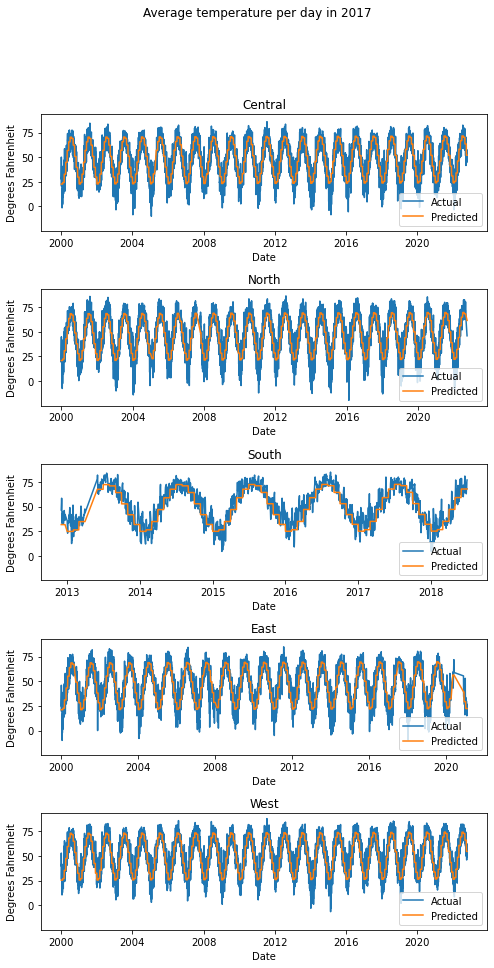

In [119]:
#recreate region dfs
central = agg_df[agg_df['Location']=="Central"]
north = agg_df[agg_df['Location']=="North"]
south = agg_df[agg_df['Location']=="South"]
east = agg_df[agg_df['Location']=="East"]
west = agg_df[agg_df['Location']=="West"]

#temperature for sample year 2017
central_2017 = central[(central['DATE']>='2017-01-01')&(central['DATE']<= '2017-12-31')]
north_2017 = north[(north['DATE']>='2017-01-01')&(north['DATE']<= '2017-12-31')]
south_2017 = south[(south['DATE']>='2017-01-01')&(south['DATE']<= '2017-12-31')]
east_2017 = east[(east['DATE']>='2017-01-01')&(east['DATE']<= '2017-12-31')]
west_2017 = west[(west['DATE']>='2017-01-01')&(west['DATE']<= '2017-12-31')]

agg_list = [central, north, south, east, west]
df_list = [central_2017, north_2017, south_2017, east_2017, west_2017]
fig, axs = plt.subplots(5, sharex = False, sharey=True, figsize = (8,15))
fig.suptitle('Average temperature per day in 2017')
fig.subplots_adjust(hspace = 0.5)
index = 0
title_list = ['Central', 'North', 'South', 'East','West']
for i in agg_list:
#for i in df_list:
    axs[index].plot(i['DATE'], i['AverageTemp'], label='Actual')
    axs[index].plot(i['DATE'], i['PredictedTemp'], label = 'Predicted')
    axs[index].set_ylabel('Degrees Fahrenheit')
    axs[index].set_xlabel('Date')
    axs[index].legend(loc='lower right')
    axs[index].set_title(title_list[index])
    index+=1

# Evaluation of Significance

Hypothesis 1: During winter the temperature for each region is significantly different from Ithaca as measured by a t-test where all p-values fell below the 5% threshold. During Spring the region North of Ithaca is the only one for which temperature is not significantly different. In Summer all the regions have temperatures significantly different than that of Ithaca's. In Fall the North is the only region with temperature not significantly different from Ithaca's. Overall this means that we fail to reject the hypothesis of significantly different temperature between regions for Winter and Summer, and we do reject that hypothesis for Spring and Fall.

Hypothesis 2: Only for the Southern region is there not a significant difference found between probability of precipitation the day after a trace was detected versus days not after a trace was detected. Z-scores were calculated for each region, where the null hypothesis was that the probability of precipitation trace is the same for the day after a trace of precipitation and a day that is not after a trace of precipitation. The alternative hypothesis is that the probability of precipitation is lower for days not after a trace of precipitation. For most regions the Z-scores were greater than -1.645, so there is a significant difference in precipitation on days after a trace, but for the Southern region the Z-score was -9.35, so we fail to reject the null hypothesis.

Hypothesis 3: Based on p-values and a 1% significance level all of the variables are considered significant, and should remain in the model since all of the p-values for the variables are less than 0.01.. Only the constant and “year” variable had p-values greater than 0, but they are still significantly below the 0.01 threshold. This implies that this model is significant, and contains good indicators for temperature.


# Interpretations and Conclusions

Based on this analysis, it can be concluded that for some seasons temperature in areas surrounding Ithaca is significantly different than in Ithaca. This is true for Summer and Winter, while for Fall and Spring a significant difference is not found in each direction, this may be because Spring and Fall are more transitional seasons whereas Summer and Winter are more extreme. The North specifically is the direction where a significant difference is not found. The Northern city is the closest one to Ithaca in this study, which may explain why there is not a significant temperature difference because it may be too close.
Only for certain regions is there a higher likelihood of precipitation following a trace day. For Ithaca, North of Ithaca, East of Ithaca, and West of Ithaca there is a significantly higher probability, but for the city chosen South of Ithaca this is not true. This could be due to different weather patterns including humidity and elevation, which could be explored in a further study.

As apparent from the graphs in hypothesis 3, a linear regression model based on latitude, longitude, year, and month is possible. In each region the actual temperature follows an arc that generally averages around 20 degrees in January, reaches a peak of around 70 degrees in July, then curves back to around 20 degrees by December, and this repeats each year. By using dummy variables, seasonality is incorporated into the model which allows the regression line for each region to follow this pattern well. Additionally for both RMSE and MAE the test value is lower than the train value, so overfitting is not a concern. When testing possible models, a model using day as a variable was considered, but for this model RMSE and MAE test values were higher than train values, so overfitting may have been present. 

There is high confidence that these conclusions could be applied beyond this project while staying in the Northeastern region, or places with climates that are similar to the Northeast. Since weather is very region dependent, and these conclusions do not include humidity, elevation, or other indicators, it is not advised to apply this model or findings to different climates.


## Data Limitations

Null values: The most consistent quantitative observations available for each location and date are temperature, elevation, precipitation, and snowfall. However, there are many other columns containing other types of observations, which have a significant amount of null values. This may make it hard to incorporate these other observations if there is not enough data, and could lead to a less accurate model. For people living in areas where some of these other attributes are present frequently, the results of this study will be less accurate since nulls don’t allow the model to incorporate these attributes.

Different length of time frames: Five cities are included in this analysis and new dataset, however different amounts of data exist for each city. Ideally 20 years of history would be included for each city, however this was not available, so there is less data to use to train a model for certain cities, which could impact accuracy of results. People in less developed cities and towns likely have less weather data, so predictions for them are likely less accurate than for people living in bigger, more developed cities with more resources to have more years of data.

Limited scope of cities: Only a total of 5 cities are included in this dataset, so conclusions from this analysis are not necessarily applicable to people in other areas. This is especially true because this dataset is centered around Ithaca, which is a Northeastern climate, however in a desert setting the results to these research questions likely will not be applicable based on this analysis. 

Attributes are not very descriptive: The attributes for different weather events are not very descriptive. This could make it difficult to incorporate the attribute columns into an analysis as it is unclear what some of the different attributes mean, especially in the context of the research questions. Similar to the limitations due to null values, many attributes are excluded since it is unclear what they represent, but for people living in areas where these attributes play a major role in weather phenomena, the results of this study will be less accurate.

Missing temperature data: For Bloomsburg, which is the city South of Ithaca chosen, temperature data is missing for many years. This is an issue because temperature is one of the most consistent columns in other cities, so it is critical to analysis. However, there are not many major cities in the radius since Ithaca is in a relatively rural setting, so finding another city with better data may not be possible. This will make predictions over time difficult when including Bloomsburg, and some conclusions will not be as true for the people of Bloomsburg as they will be for the other cities chosen.


# Acknowledgments
- The National Weather Service for providing historical data.
- Penn State Eberly College of Science (https://online.stat.psu.edu/stat415/lesson/9/9.4) for a lesson on comparing proportions which is used in hypothesis 2.
- Stack Overflow (https://stackoverflow.com/questions/31726643/how-to-plot-in-multiple-subplots) for providing information on creating subplots which was useful for generating plots for each region.
